In [74]:
import tensorflow as tf
from tensorflow.keras import layers

### Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            pos=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled Dot Product Attention
def scaled_dot_product_attention(q, k, v, mask):     #(Q, K, V는 다 4D 텐서: (batch_size, num_heads, seq_len, depth))
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [75]:
### Multi-Head Attention
class MultiHeadAttention(layers.Layer):          #num_head = 헤드개수 <예)8개>
    def __init__(self, d_model, num_heads):        #d_model: 전체 출력 차원 (예: 512)
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)      #여러 head를 만들려면 Q, K, V를 한번 linear transform 해줘야 함. (독립적으로 head들이 일할 수 있도록)
#마지막에 여러 head를 이어붙인 걸 다시 d_model 크기로 맞춰주는 Dense 레이어.
    def split_heads(self, x, batch_size):
      ## 1. (batch_size, seq_len, d_model) → (batch_size, seq_len, num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.num_heads * self.depth))

        output = self.dense(concat_attention)
        return output


   #[입력 Q, K, V]
       #  -> (각각 Dense에 통과)
       #  -> (split_heads로 여러 head로 나눔)
       #  -> (각 head마다 scaled dot-product attention 계산)
       #  -> (head들 concat)
       #  -> (마지막 Dense로 출력)

In [76]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [77]:
### Encoder Layer
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [78]:
### Encoder
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)

        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask=mask, training=training)

        return x  # (batch_size, input_seq_len, d_model)

In [79]:
### Transformer Classifier (Main Model)
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding,
                 num_classes=4, rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, maximum_position_encoding, rate)
        self.dropout = layers.Dropout(rate)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        mask = create_padding_mask(inputs)
        x = self.encoder(inputs, mask = mask, training=training)  # (batch_size, seq_len, d_model)
        cls_token = x[:, 0, :]
        x = self.dropout(cls_token, training=training)
        return self.classifier(x)                   # (batch_size, num_classes)

In [80]:
#########################################################################################################################

In [81]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer

# 1. 헤더 없는 CSV 로드
data_train = pd.read_csv("twitter_training.csv", header=None)
data_test= pd.read_csv("twitter_validation.csv", header=None)
data_train.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet comment"]
data_test.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet comment"]
# 2. 필요 없는 열 제거
data_train = data_train.drop(columns=["Tweet ID"])
data_test = data_test.drop(columns=["Tweet ID"])
# 3. 소문자 변환
data_train["Tweet comment"] = data_train["Tweet comment"].astype(str).str.lower()
data_train["Entity"] = data_train["Entity"].astype(str).str.lower()

data_test["Tweet comment"] = data_test["Tweet comment"].astype(str).str.lower()
data_test["Entity"] = data_test["Entity"].astype(str).str.lower()

#결측치 확인
data_test.isnull().sum()
data_train.isnull().sum()

,0
Entity,0
Sentiment,0
Tweet comment,0


In [82]:
print(len(data_train))
print(len(data_test))

74682
1000


In [83]:
# 4. input_text 생성
data_train["input_text"] = data_train.apply(
    lambda x: f"{x['Tweet comment']} [SEP] {x['Entity']}",
    axis=1
)  #[CLS] 문장1 [SEP] 문장2 [SEP]

data_test["input_text"] = data_test.apply(
    lambda x: f"{x['Tweet comment']} [SEP] {x['Entity']}",
    axis=1
)  #[CLS] 문장1 [SEP] 문장2 [SEP]

In [84]:
# 5. 토크나이저 (서브워드 자동 사용)
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#encodings_train = tokenizer(
#    data_train["input_text"].tolist(),
#    padding=True,
#    truncation=True,
#    max_length=128,
#    return_tensors="tf",
#    add_special_tokens=True
#)

#encodings_test = tokenizer(
#    data_test["input_text"].tolist(),
#    padding=True,
#    truncation=True,
#    max_length=128,
#    return_tensors="tf",
#    add_special_tokens=True
#)

# 6. 라벨 인코딩
#label_map = {"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant": 3}  #라벨 맵핑

#data_train["label"] = data_train["Sentiment"].map(label_map)
#labels_train = data_train["label"].values

#data_test["label"] = data_test["Sentiment"].map(label_map)
#labels_test = data_test["label"].values

최소 길이: 4
최대 길이: 128
평균 길이: 35.83295841032645
중간값 길이: 32.0
95% percentile: 77.0
99% percentile: 94.0


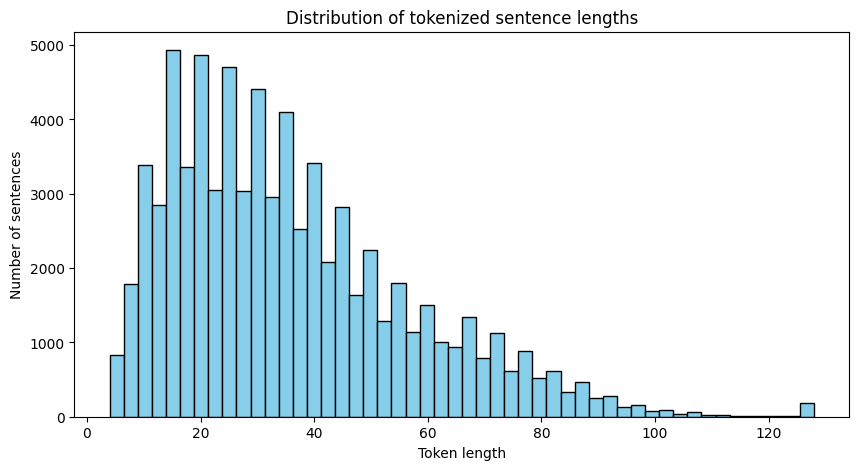

In [87]:
import matplotlib.pyplot as plt
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

##########################------max_len을 결정하기 위해서 토큰수의 분포를 본다.------########################################


# 각 문장의 토큰 길이 계산
# Tensor → numpy로 변환 (TF나 Torch 상관없이 안전)
input_ids = np.array(encodings_train["input_ids"])

# 각 샘플의 실제 토큰 길이 계산 (패딩 없이 원래 길이)
token_lengths = [np.count_nonzero(ids) for ids in input_ids]
# 또는 패딩이 0이 아니라 [PAD] 토큰이라면 np.count_nonzero != pad_id 사용해야 함

# 1. 통계 확인
print("최소 길이:", np.min(token_lengths))
print("최대 길이:", np.max(token_lengths))
print("평균 길이:", np.mean(token_lengths))
print("중간값 길이:", np.median(token_lengths))
print("95% percentile:", np.percentile(token_lengths, 95))
print("99% percentile:", np.percentile(token_lengths, 99))

# 2. 히스토그램 시각화
plt.figure(figsize=(10,5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Token length")
plt.ylabel("Number of sentences")
plt.title("Distribution of tokenized sentence lengths")
plt.show()



In [88]:
encodings_train = tokenizer(
    data_train["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf",
    add_special_tokens=True
)

encodings_test = tokenizer(
    data_test["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf",
    add_special_tokens=True
)

# 6. 라벨 인코딩
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant": 3}  #라벨 맵핑

data_train["label"] = data_train["Sentiment"].map(label_map)
labels_train = data_train["label"].values

data_test["label"] = data_test["Sentiment"].map(label_map)
labels_test = data_test["label"].values

In [89]:
example = data_train["input_text"].iloc[0]

print(tokenizer.tokenize(example))
print(tokenizer.encode(example))  # 숫자 토큰
#cls가 101、 sep가 102이다。

['im', 'getting', 'on', 'border', '##lands', 'and', 'i', 'will', 'murder', 'you', 'all', ',', '[SEP]', 'border', '##lands']
[101, 10047, 2893, 2006, 3675, 8653, 1998, 1045, 2097, 4028, 2017, 2035, 1010, 102, 3675, 8653, 102]


In [103]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

x_train = encodings_train["input_ids"]
x_test = encodings_test["input_ids"]

y_train = labels_train    #정답 레이블
y_test = labels_test        #정답 레이블

x_train_np = x_train.numpy() if tf.is_tensor(x_train) else x_train
y_train_np = y_train.numpy() if tf.is_tensor(y_train) else y_train

# train-validation split (80% 학습, 20% 검증)
x_train_off, x_val, y_train_off, y_val = train_test_split(
    x_train_np, y_train_np, test_size=0.2, random_state=42, shuffle=True
)

y_train_off = tf.one_hot(y_train_off, depth=4) #원 핫 인코딩
y_val = tf.one_hot(y_val, depth=4)  #원 핫 인코딩
y_test = tf.one_hot(y_test, depth=4)

batch_size = 16

# Dataset 생성
train = tf.data.Dataset.from_tensor_slices((x_train_off, y_train_off)).shuffle(10000).batch(batch_size)

val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


In [104]:
print(labels_train[:20])


[2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2]


In [105]:
print(y_val[:20])



tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]], shape=(20, 4), dtype=float32)


In [106]:
#num_layers = 2
#d_model = 128
#num_heads = 4
#dff = 256
#vocab_size = tokenizer.vocab_size
#max_len = 128
#num_classes = 4   # negative / neutral / positive / irrelevant


#num_layers = 3      # 레이어 1개 늘려서 모델 깊게
#d_model = 256       # 표현력 증가
#num_heads = 8       # 멀티헤드 늘리기 (d_model % num_heads = 0)
#dff = 512           # FFN 용량 증가
#max_len = 128       # 그대로

#num_layers = 3      # 레이어 1개 추가
#d_model = 256       # 임베딩 차원 증가
#num_heads = 8       # 멀티헤드 증가 (d_model % num_heads == 0)
dff = 512           # FFN 내부 차원 증가
vocab_size = tokenizer.vocab_size


model = TransformerClassifier(
    num_layers=3,
    d_model=256,
    num_heads=8,
    dff=dff,
    input_vocab_size=vocab_size,
    maximum_position_encoding=128,
    num_classes= 4,
    rate=0.3
)


In [107]:
optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [108]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    train,
    validation_data=val ,
    epochs=30,
    callbacks=[early_stop]
)



Epoch 1/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 92s 19ms/step - accuracy: 0.3962 - loss: 1.4032 - val_accuracy: 0.6945 - val_loss: 0.8030
Epoch 2/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.7169 - loss: 0.7471 - val_accuracy: 0.7904 - val_loss: 0.5677
Epoch 3/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 62s 16ms/step - accuracy: 0.8182 - loss: 0.4954 - val_accuracy: 0.8270 - val_loss: 0.5313
Epoch 4/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.8642 - loss: 0.3715 - val_accuracy: 0.8603 - val_loss: 0.4260
Epoch 5/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 62s 17ms/step - accuracy: 0.8893 - loss: 0.2998 - val_accuracy: 0.8741 - val_loss: 0.4072
Epoch 6/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 62s 16ms/step - accuracy: 0.9043 - loss: 0.2541 - val_accuracy: 0.8744 - val_loss: 0.4129
Epoch 7/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.9164 - loss: 0.2243 - val_accuracy: 0.8913 - val_loss: 0.3850
Epoch 8/30
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.9279 -

In [109]:
model.build(input_shape=(None, max_len))
model.summary()


Model: "transformer_classifier_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_6 (Encoder)             │ ?                      │     9,394,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,187,918 (107.53 MB)

 Trainable params: 9,395,972 (35.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,791,946 (71.69 MB)

In [110]:
y_pred = model.predict(test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


In [111]:
y_true = labels_test  # 정수 라벨 (원핫 아님!!!11)


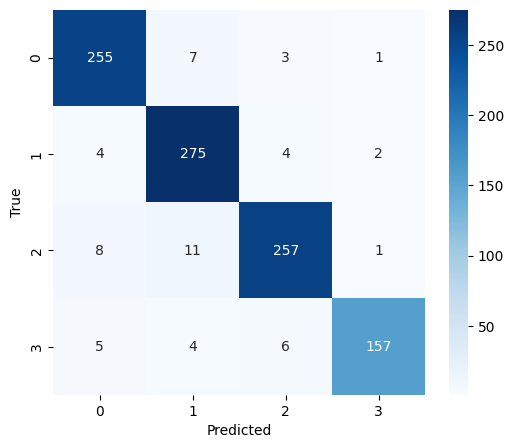

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


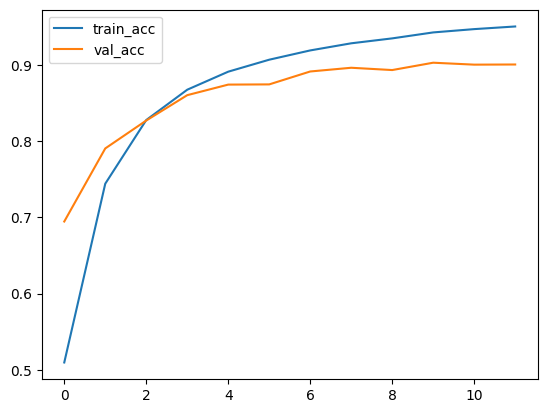

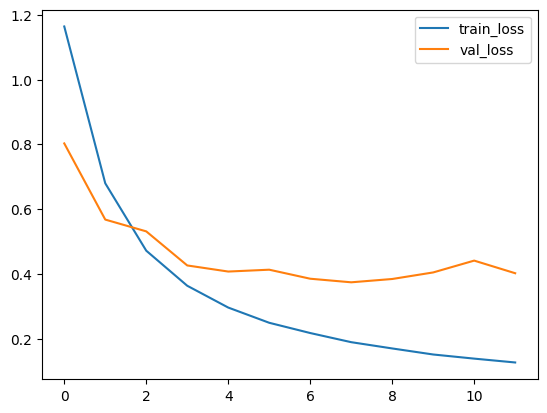

In [113]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [114]:
import numpy as np
import tensorflow as tf

def preprocess_sentence(sentence, entity, tokenizer, max_len=128):   #직접 문장 넣어서 확인해보기
    sentence = sentence.lower()
    entity = entity.lower()

    combined = "[CLS] " + sentence + " [SEP] " + entity

    encoded = tokenizer(
        combined,
        add_special_tokens=False,   #직접 CLS/SEP 넣었으니까
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )["input_ids"]

    return encoded  # (1, max_len)


def predict_sentiment(model, sentence, entity, tokenizer, max_len=128):
    x = preprocess_sentence(sentence, entity, tokenizer, max_len)

    preds = model.predict(x)
    label_id = np.argmax(preds)

    id2label = {
        0: "negative",
        1: "neutral",
        2: "positive",
        3: "irrelevant"
    }

    return id2label[label_id], preds



# ============================
# 테스트 실행
# ============================

sentence = "so i spent a few hours doing something for fun... if you don't know i'm a huge @ borderlands fan and maya is one of my favorite characters."
entity = "borderlands"

label, raw = predict_sentiment(model, sentence, entity, tokenizer)

print("예측 라벨:", label)
print("raw:", raw)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
예측 라벨: positive
raw: [[1.0739346e-05 9.9863146e-06 9.9996340e-01 1.5887201e-05]]


In [115]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# 모델 예측
y_pred_probs = model.predict(test)
y_pred_labels = y_pred_probs.argmax(axis=1)

# 각 지표 계산
precision = precision_score(y_true, y_pred_labels, average='macro')
recall    = recall_score(y_true, y_pred_labels,   average='macro')
f1        = f1_score(y_true, y_pred_labels,       average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# 클래스별 상세 보고서
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred_labels))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.9476082643202208
Recall: 0.941036857213136
F1-score: 0.9438966119416043

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       266
           1       0.93      0.96      0.95       285
           2       0.95      0.93      0.94       277
           3       0.98      0.91      0.94       172

    accuracy                           0.94      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

